In [15]:
import pandas as pd

In [16]:
# paths to files with data
path_mnist_train = 'mnist_train.csv'
path_dice = 'dice.csv'
path_cifar_all = 'cifar_all.csv'

# load data from csv
df_mnist_train = pd.read_csv(path_mnist_train, header=None)
df_dice = pd.read_csv(path_dice, header=None)
df_cifar_all = pd.read_csv(path_cifar_all, header=None)

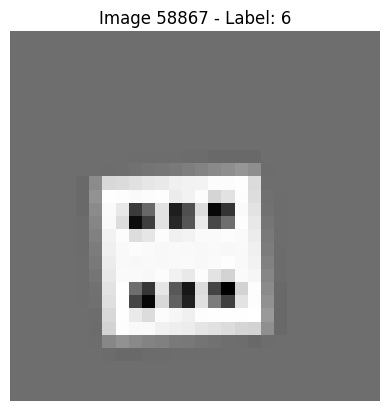

In [17]:
# test display

import matplotlib.pyplot as plt

image_index = 118867 % 60000

image_data = df_dice.iloc[image_index, 1:].values.reshape(28, 28)
plt.imshow(image_data, cmap='gray')
plt.title(f'Image {image_index} - Label: {df_dice.iloc[image_index, 0]}')
plt.axis('off')
plt.show()

Epoch [1/10], Train Loss: 1.7905, Val Loss: 1.7886
Epoch [2/10], Train Loss: 1.7811, Val Loss: 1.7664
Epoch [3/10], Train Loss: 1.6926, Val Loss: 1.5352
Epoch [4/10], Train Loss: 1.3051, Val Loss: 1.1548
Epoch [5/10], Train Loss: 1.0630, Val Loss: 0.9821
Epoch [6/10], Train Loss: 0.9302, Val Loss: 0.9226
Epoch [7/10], Train Loss: 0.7922, Val Loss: 0.6656
Epoch [8/10], Train Loss: 0.6161, Val Loss: 0.4853
Epoch [9/10], Train Loss: 0.3976, Val Loss: 0.2665
Epoch [10/10], Train Loss: 0.2289, Val Loss: 0.1528
Precision of classification on dataset: 96.77%


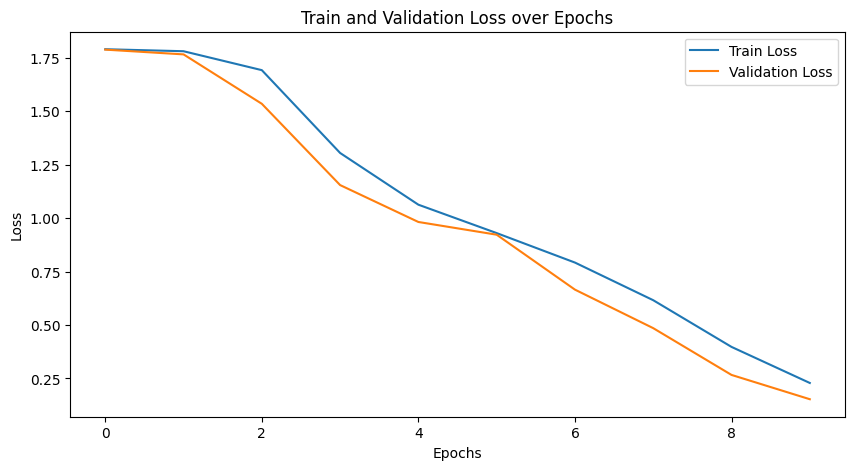

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CNN model definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 6)  # Zmieniono na 6 wyjść

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Loading data
path_dice = 'dice.csv'
df_dice = pd.read_csv(path_dice, header=None)

# Division of data into features (cube images) and labels (number of spots on the cube)
X = df_dice.iloc[:, 1:].values.reshape(-1, 1, 28, 28)  # Przekształcamy dane na odpowiednią postać tensora
y = df_dice.iloc[:, 0].values - 1  # Zmniejszenie wartości etykiet o 1 (0-5 zamiast 1-6)

# Data normalization
X = X.astype(np.float32) / 255.0

# Creating dataset
dataset = TensorDataset(torch.tensor(X), torch.tensor(y))

# Division of the dataset into training, validation and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model initialization
model = CNNModel()

# Loss function and optimizer definition
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning model
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Model validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Model evaluation on the test set
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Precision of classification on dataset: {100 * correct / total:.2f}%')

# Tworzenie wykresu strat
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss over Epochs')
plt.show()
